# Settings, Directory Specs, and Imports

In [1]:
# 0 = no streamlit
# 1 = test user inputs
# 2 = run in streamlit
streamlit_status = 0
#file_name_pickle_read = 'model_2020_06_06_1105.pickle'
do_plots = 0

dir_read = '/Users/rachellehorwitz/Documents/ViTalErt/data/filtered02/'
#dir_read = '/Users/rachellehorwitz/Documents/VTAlert/over18_eicu/'

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import streamlit as st
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import pickle
from datetime import datetime

matplotlib.rcParams.update({'font.size': 22})

In [2]:
st.title('ViTalErt: Risk Monitoring for Venous Thromboembolism in ICU Patients')

# Function Definitions

In [3]:
def now_to_str():
    now = str(datetime.now())
    return now[0:4] + '_' + now[5:7] + '_' + now[8:10] + '_' + now[11:13] + now[14:16]

# eICU Data Wrangling

In [4]:
# Read files from csv
patient = pd.read_csv(dir_read + 'patient.csv')
admissiondx = pd.read_csv(dir_read + 'admissiondx.csv')
diagnosis = pd.read_csv(dir_read + 'diagnosis.csv')
ptusid_pos = pd.read_csv(dir_read + 'pos_ptunitstayid.csv')

# Create dataframe of patientunitstayids in negative class
tmp = patient[~patient['patientunitstayid'].isin(ptusid_pos['patientunitstayid'])]
ptusid_neg = tmp[['patientunitstayid']]

# Create labels
ptusid_neg = ptusid_neg.assign(label=0)
ptusid_pos = ptusid_pos.assign(label=1)

# Add labels to "patient" dataframe and move 'label' column to left
ptusid_w_label = pd.concat([ptusid_pos, ptusid_neg])
ptusid_w_label.shape[0]
ptusid_w_label = ptusid_w_label.set_index('patientunitstayid')
patient = patient.set_index('patientunitstayid')
patient = patient.join(ptusid_w_label)

# Move 'label' column to left
cols = list(patient.columns)
cols = [cols[-1]] + cols[:-1]
patient = patient[cols]

# Remove patients who weigh less than 40 kg or more than 400 kg
patient = patient[(patient['admissionweight'] > 40) & \
                   (patient['admissionweight'] < 400)]

In [5]:
patient_pos = patient[patient['label']==1]
patient_neg = patient[patient['label']==0]
patient[patient['label']==1].shape[0]

1970

# Defining X and y

In [6]:
# Define X and y
X = patient[['age', 'admissionweight']]
y = patient['label']

# Partition and train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [7]:
if do_plots == 1:
    %matplotlib notebook
    import seaborn as sns

    sns.distplot(patient['age'], bins=15)
    plt.xlabel('Age (yrs)')
    plt.title('Distribution of Age Among All Patients')

    plt.figure()
    sns.distplot(patient['admissionweight'], bins=200)
    plt.xlabel('Admission Weight (kg)')
    plt.title('Distribution of Weight Among All Patients')

    plt.figure()
    sns.distplot(patient_pos['admissionweight'], color='red')
    sns.distplot(patient_neg['admissionweight'], color='blue')
    plt.xlabel('Admission Weight (kg)')
    plt.legend('VTE', 'No VTE')

    plt.figure()
    sns.distplot(patient_pos['age'], color='red', bins=15)
    sns.distplot(patient_neg['age'], color='blue', bins=15)
    plt.xlabel('Age (years)')

    plt.figure()
    sns.distplot(patient_pos['admissionweight'], color='red', bins=100)
    sns.distplot(patient_neg['admissionweight'], color='blue', bins=200)
    plt.xlabel('Admission Weight (kg)')

In [8]:
if streamlit_status == 1:
    age = 30
    admissionweight = 50

if streamlit_status == 2:
    age = st.slider('Age', 19, 90)
    admissionweight = st.slider('Admission Weight (kg)', 40, 300)

if (streamlit_status == 1) | (streamlit_status == 2): 
    input_data = {'age': [age], 'admissionweight': [admissionweight]}
    X_test = pd.DataFrame(input_data, columns=['age', 'admissionweight'])

# Model and Predict

In [9]:
logisticRegr_sc = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced'))
logisticRegr_sc.fit(X_train, y_train)
file_name_pickle = 'model_' + now_to_str() + '.pickle'
pickle.dump(logisticRegr_sc, open(file_name_pickle, 'wb'))

# if (streamlit_status == 1) | (streamlit_status == 2):
#     logisticRegr_sc = pickle.load(open(file_name_pickle_read, 'rb'))

predictions_sc = logisticRegr_sc.predict(X_test)
prob_sc = logisticRegr_sc.predict_proba(X_test)[:,1]
#lprob_sc = logisticRegr_sc.predict_log_proba(X_test)[:,1]

scores_sc = logisticRegr_sc.score(X_test, y_test)
print(scores_sc)

0.5361682529935523


In [10]:
print('prob_sc:  min = ' + str(np.min(prob_sc)))
print('\t    max = ' + str(np.max(prob_sc)))

prob_sc:  min = 0.3726293872831279
	    max = 0.7923519647394158


160880 patients in negative class
1970 patients in positive class
If you predict 0 all the time, accuracy is 0.98790%


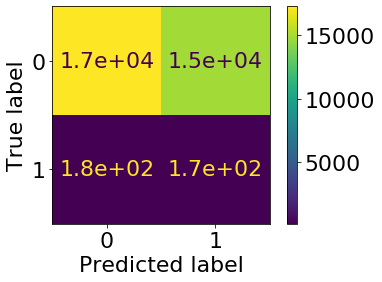

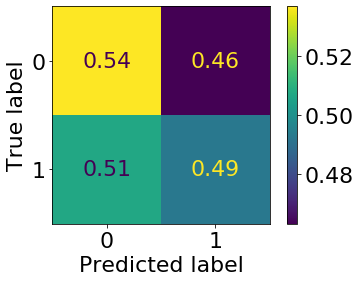

In [11]:
# Print baseline accuracy
N0_bl = patient[patient['label']==0].shape[0]
N1_bl = patient[patient['label']==1].shape[0]
print('{:d} patients in negative class'.format(N0_bl))
print('{:d} patients in positive class'.format(N1_bl))
print('If you predict 0 all the time, accuracy is {:.5f}%'.format(N0_bl/(N0_bl+N1_bl)))

cm = confusion_matrix(list(y_test), predictions_sc)
plot_confusion_matrix(logisticRegr_sc, X_test, list(y_test))
plot_confusion_matrix(logisticRegr_sc, X_test, list(y_test),  normalize='true')

# Breakpoint